# RCP Simulations


## 1. Loading Dataset & Model

Here we perform some simulation using the Representative Concentration Pathways (RCP) datasets, which include emissions _projections_ (not emissions) which assume variouse mitigating factors for all major anthropogenic greenhouse gases from $1765$ to $2500$. We only consider CO2 emissions for fossil, industrial, and land use-related emissions in the $4$ RCP scenario and its mean. We refer the reader to Meinshausen et al., [The RCP greenhouse gas concentrations and their extensions from 1765 to 2300](https://link.springer.com/article/10.1007/s10584-011-0156-z) for further details. See `data/source/EmiAndConcData` for the full source dataset and `data/emissions` for the cleaned-up snippet of the dataset that is used for our experiment only.

We load the calibrated model, which has been trained in `\solver` and saved in `\results`. The model equilibrium masses, $\mathbf{m}^{eq}$, have been calibrated to the pre-industrial year which assume to correspond to RCP dataset starting year of $1765$


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import copy
import pickle

import lib_operations as operations
import lib_data_load as data_load
from lib_models import model_3sr,model_4pr

_plot_vis = {}
_plot_vis['color']  = ['black','red','blue','green','orange','purple','brown','pink']
_plot_vis['marker'] = ['o','v','s','D','X']

make_plot = lambda n,m,s=[1,1]: plt.subplots(n,m,figsize=(m*4*s[0],n*2.6*s[1]),squeeze=False,layout='tight')

# shortcut for finding index of given value
inx_find = lambda x, val: int(np.where(x == val)[0])

np.set_printoptions(suppress=True)
plt.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

# Load data


In [11]:
# load the results including the c_set 
with open(r"results_analysis.pickle", "rb") as handle:
    _results = pickle.load(handle)

_model_set = [model_3sr,model_4pr]

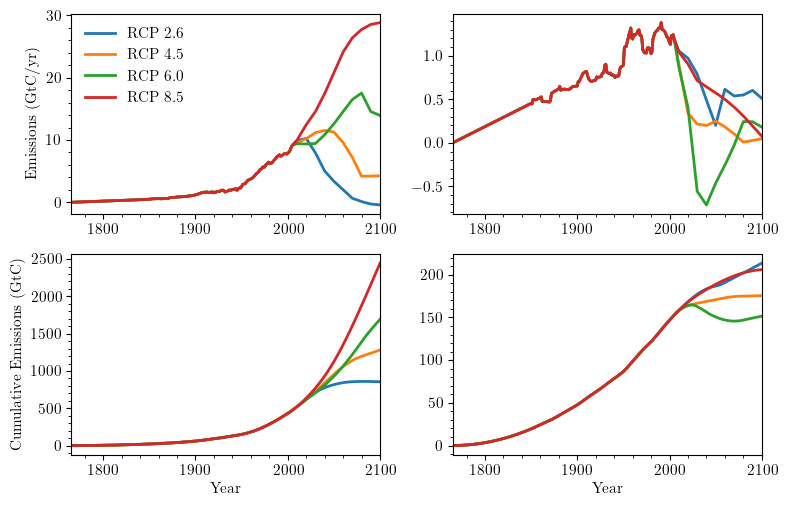

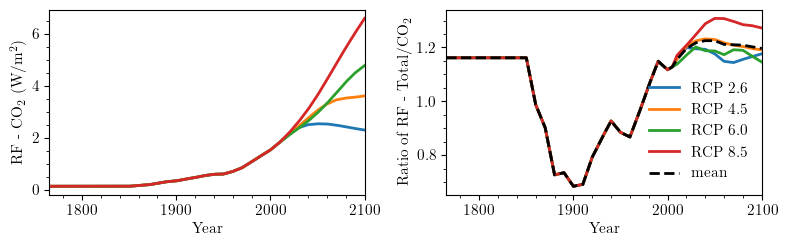

In [12]:
fig_1, axs_1 = make_plot(2,2)
fig_2, axs_2 = make_plot(1,2)
T_start = 1765
T_end   = 2100

scenerio_set_name = ['RCP 2.6', 'RCP 4.5', 'RCP 6.0', 'RCP 8.5']


[reactive_forcing_co2,reactive_forcing_ratio,reactive_forcing_year]=data_load.reactive_forcing(T_start=T_start,T_end=T_end)

for i, scenerio in enumerate(['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']):
    
    [data_val,data_year] = data_load.cmip_emission(scenerio_name=scenerio,T_start=T_start,T_end=T_end,emission_type='fossil+land')
    axs_1[0,0].plot(data_year,data_val,label=scenerio_set_name[i],linewidth=2)
    axs_1[1,0].plot(data_year,np.cumsum(data_val),label=scenerio_set_name[i],linewidth=2)
    
    [data_val,data_year] = data_load.cmip_emission(scenerio_name=scenerio,T_start=T_start,T_end=T_end,emission_type='land')
    axs_1[0,1].plot(data_year,data_val,label=scenerio_set_name[i],linewidth=2)
    axs_1[1,1].plot(data_year,np.cumsum(data_val),label=scenerio_set_name[i],linewidth=2)


    [a,year]=data_load.cmip_concentration(scenerio_name=scenerio,concentration_type='CO2EQ',T_start=T_start,T_end=T_end)
    [b,year]=data_load.cmip_concentration(scenerio_name=scenerio,concentration_type='CO2',T_start=T_start,T_end=T_end)
    [c,year]=data_load.cmip_concentration(scenerio_name=scenerio,concentration_type='KYOTO-CO2EQ',T_start=T_start,T_end=T_end)


    axs_2[0,0].plot(year,reactive_forcing_co2[scenerio],label=scenerio_set_name[i],linewidth=2,linestyle='-')
    axs_2[0,1].plot(year,reactive_forcing_ratio[scenerio],label=scenerio_set_name[i],linewidth=2,linestyle='-')
    #axs_2[0,1].hlines(y=np.mean(temp[-100:]),xmin=1765,xmax=2100)
    
    #axs_2[0,1].hlines(y=np.mean(c/b),xmin=1765,xmax=2100)
   
axs_2[0,1].plot(year,reactive_forcing_ratio['avg'],label='mean',linewidth=2,color='black',linestyle='--')

axs_2[0,0].minorticks_on()
axs_2[0,1].minorticks_on()
axs_1[0,0].minorticks_on()
axs_1[0,1].minorticks_on() 
axs_1[1,0].minorticks_on() 
axs_1[1,1].minorticks_on() 

axs_1[0,0].legend(frameon=False,loc='upper left',ncol=1)
axs_2[0,1].legend(frameon=False,loc='lower right',ncol=1)

axs_1[0,0].set_ylabel(r'Emissions (GtC/yr)')
#axs[0,1].set_ylabel(r'Landuse-Related Emis. (GtC/yr)')

axs_1[0,0].set_xlim(left=data_year[0],right=data_year[-1])
axs_1[0,1].set_xlim(left=data_year[0],right=data_year[-1])

axs_2[0,0].set_xlim(left=data_year[0],right=data_year[-1])
axs_2[0,1].set_xlim(left=data_year[0],right=data_year[-1])

#axs_2[0,0].set_ylim(bottom=0.7,top=1.3)
#axs_2[0,1].set_ylim(bottom=0.7,top=1.3)

axs_1[1,0].set_ylabel(r'Cumulative Emissions (GtC)')
#axs[1,1].set_ylabel(r'Cumulative Landuse-Related Emis. (GtC)')
axs_2[0,0].set_ylabel(r'RF - CO$_2$ ($\textrm{W}/\textrm{m}^2$)')
axs_2[0,1].set_ylabel(r'Ratio of RF - Total/CO$_2$')

axs_1[1,0].set_xlabel(r'Year')    
axs_1[1,1].set_xlabel(r'Year')  
axs_2[0,0].set_xlabel(r'Year')    
axs_2[0,1].set_xlabel(r'Year')  

axs_1[1,0].set_xlim(left=data_year[0],right=data_year[-1])
axs_1[1,1].set_xlim(left=data_year[0],right=data_year[-1])

fig_1.savefig('doc/fig/simulations_RCP.png',dpi=300) 
fig_2.savefig('doc/fig/simulations_RF.png',dpi=300) 

#Pulse 100 GTC

/var/folders/d2/9qb3m2t14ts4c5lnwscq22b80000gn/T/ipykernel_75986/882218141.py:79: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[1,model_inx].set_xlim(left=0,right=500)


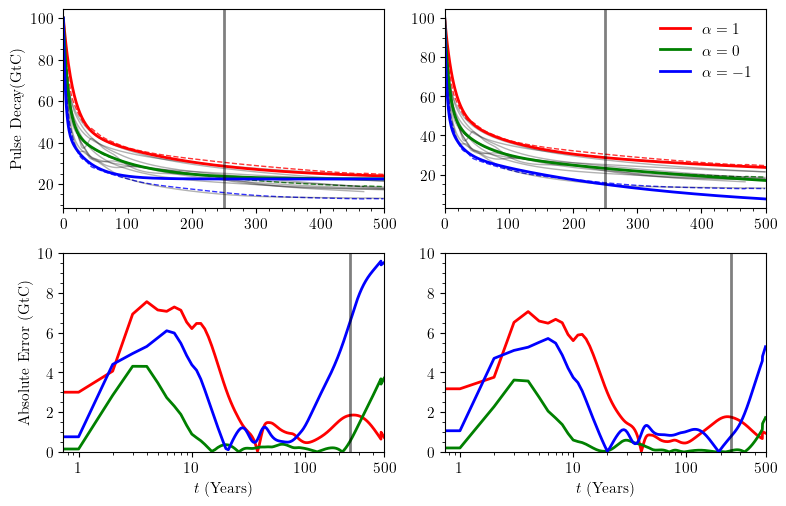

In [13]:
def plot_bound_fit(results,mode_name_set = ['3SR','4PR']):

    benchmark_list = ['MMMU','MMM','MMMD','NCAR','BERN3D','BERN25D', 'CLIMBER2','DCESS','GENIE','LOVECLIM','MESMO','UVIC29','BERNSAR']#['NCAR','BERN3D','BERN25D', 'CLIMBER2','DCESS','GENIE','LOVECLIM','MESMO','UVIC29','BERNSAR']
    T              = 500
    T_sim          = T

    M_sim_set   = {}
    M_pulse_set = []

    fig, axs = make_plot(2,2)
    for model_inx,model_name in enumerate(['3SR','4PR']):   
    
        model = results[model_name]['model']
        info  = model()
        A     = results[model_name]['A']
        a     = results[model_name]['a']
        m_eq  = results[model_name]['m_eq']
        c     = results[model_name]['c']

        [data_pulse_mmmmu,_] = data_load.pulse_fraction(test_type='MMMU',T=T) 
        data_pulse_mmmmu    *= 100
        [data_pulse_mmmm,_]  = data_load.pulse_fraction(test_type='MMM' ,T=T) 
        data_pulse_mmmm     *= 100
        [data_pulse_mmmmd,_] = data_load.pulse_fraction(test_type='MMMD',T=T) 
        data_pulse_mmmmd    *= 100

        M_pulse_set.append(data_pulse_mmmmu)
        M_pulse_set.append(data_pulse_mmmm)
        M_pulse_set.append(data_pulse_mmmmd)

        m0    = np.zeros(A.shape[0])
        m0[0] = 100

        [m_mmmu,_,_] = operations.simulate(A=(A*c[0]) ,m0=m0,T=T_sim)
        [m_mmm ,_,_] = operations.simulate(A=(A*c[1]) ,m0=m0,T=T_sim)
        [m_mmmd,_,_] = operations.simulate(A=(A*c[2]) ,m0=m0,T=T_sim)

        M_sim_set[model_name] = []
        M_sim_set[model_name].append(m_mmmu)
        M_sim_set[model_name].append(m_mmm)
        M_sim_set[model_name].append(m_mmmd)

        for i,benchmark_i in enumerate(benchmark_list):
            [d,_] = data_load.pulse_fraction(test_type=benchmark_i,T=T) 
            d = d * 100

            if benchmark_i=='MMMU':
                axs[0,model_inx].plot(d, linewidth=1,alpha=.8,color='red',linestyle='--')
            elif benchmark_i=='MMM':
                axs[0,model_inx].plot(d  , linewidth=1,alpha=.8,color='green',linestyle='--')
            elif benchmark_i=='MMMD':
                axs[0,model_inx].plot(d, linewidth=1,alpha=.8,color='blue',linestyle='--')
            else:
                axs[0,model_inx].plot(d,linewidth=1,alpha=.3,color='black')

        #label = model_name + r'$(\alpha=1)$'
        label = r'$\alpha=1$'
        axs[0,model_inx].plot(M_sim_set[model_name][0][0,:],linewidth=2,alpha=1,label=label,color='red')
        axs[1,model_inx].semilogx((np.abs( M_sim_set[model_name][0][0,0:T]-M_pulse_set[0])),linewidth=2,alpha=1,label=label,color='red')

        #label = model_name + r'$(\alpha=0)$'
        label = r'$\alpha=0$'
        axs[0,model_inx].plot(M_sim_set[model_name][1][0,:],linewidth=2,alpha=1,label=label,color='green')
        axs[1,model_inx].semilogx((np.abs( M_sim_set[model_name][1][0,0:T]-M_pulse_set[1])),linewidth=2,alpha=1,label=label,color='green')

        #label = model_name + r'$(\alpha=-1)$'
        label = r'$\alpha=-1$'
        axs[0,model_inx].plot( M_sim_set[model_name][2][0,:],linewidth=2,alpha=1,label=label,color='blue')
        axs[1,model_inx].semilogx((np.abs( M_sim_set[model_name][2][0,0:T]-M_pulse_set[2])),linewidth=2,alpha=1,label=label,color='blue')
        
        axs[0,model_inx].axvline(250,linewidth=2, color='k', linestyle='-',alpha=0.5)

        axs[0,model_inx].minorticks_on()
        axs[0,model_inx].set_xlim(left=0,right=T)

        axs[1,model_inx].axvline(250,linewidth=2, color='k', linestyle='-',alpha=0.5)
        axs[1,model_inx].minorticks_on()
        axs[1,model_inx].set_ylim(bottom=0,top=10)
        axs[1,model_inx].set_xlim(left=0,right=500)
        axs[1,model_inx].set_xticks([1,10,100,500])
        axs[1,model_inx].set_xticklabels([1,10,100,500])

    axs[0,0].set_ylabel(r'Pulse Decay(GtC)')
    axs[1,0].set_ylabel(r'Absolute Error (GtC)')
    axs[-1,0].set_xlabel(r'$t$ (Years)') 
    axs[-1,1].set_xlabel(r'$t$ (Years)') 
    axs[0,-1].legend(loc='upper right' ,frameon=False,ncol=1)  
    fig.savefig('doc/fig/simulations_pulse_decay.png',dpi=300) 

plot_bound_fit(results=_results)

# integrate to current conditions for Econ Model


In [14]:
#Load model results
_results['4PR-X'] = copy.copy(_results['4PR'])

# start simulation at 1765
[emis_val,emis_year]    = data_load.cmip_emission(scenerio_name='RCP8.5',T_start=1765,T_end=2100,emission_type='fossil+land')
[emis_val_l,emis_year ] = data_load.cmip_emission(scenerio_name='RCP8.5',T_start=1765,T_end=2100,emission_type='land')

m_at_current = 2.12*421

for model_inx,model_name in enumerate(_results.keys()): 

    model = _results[model_name]['model'] 
    info= model()

    A    = _results[model_name]['A']
    m_eq = _results[model_name]['m_eq']
                
    m_sim = []
    m_sim.append(m_eq)
                    
    e = np.zeros(len(m_eq))
                
    t = 0
    while m_sim[-1][0]< m_at_current:

        if 'X' in model_name:
            e[0]  = emis_val[t]
            e[-1] = -emis_val_l[t]
        else:
            e[0]=emis_val[t]

        m_sim+=[ A@m_sim[-1] +m_sim[-1] +  e ]

        e = e * 0.0

        t+=1

    m_sim=np.array(m_sim).T

    _results[model_name]['m_ini']         =  np.round(m_sim[:,-1] ,1)  
    _results[model_name]['t_current']     =  1765+t   
    _results[model_name]['t_current_inx'] = t
    
operations.tabulate(results=_results,vars=['m_ini','t_current','t_current_inx'])

import pickle
import copy

results_sim = copy.deepcopy(_results)

# open a file, where you ant to store the data
with open('results_sim.pickle', 'wb') as handle:
    pickle.dump(results_sim, handle, protocol=pickle.HIGHEST_PROTOCOL)


+-----------------------------------------------------------------------------------------------------------------+
|                                                      Table                                                      |
+-------+----------------+------------------------+-----------------------------------+-----------+---------------+
| model | benchmark_name |          rho           |               m_ini               | t_current | t_current_inx |
+-------+----------------+------------------------+-----------------------------------+-----------+---------------+
|  3SR  |      MMM       | [0.01   0.0001 0.    ] |       [ 897.1 1020.8 1399. ]      |    2025   |      260      |
|  4PR  |      MMM       | [0.01   0.0001 0.0001] | [  896.8  1267.3 37278.3   553.6] |    2025   |      260      |
| 4PR-X |      MMM       | [0.01   0.0001 0.0001] | [  893.3  1244.8 37271.1   538.3] |    2034   |      269      |
+-------+----------------+------------------------+---------------------

# RCP Emission $\to$ Concentrations $\to$ Temprature


/var/folders/d2/9qb3m2t14ts4c5lnwscq22b80000gn/T/ipykernel_75986/3346197134.py:27: RuntimeWarning: Mean of empty slice
  axs_temp[i,j].plot(temp_year,np.nanmean(temp_val,0),linewidth=1,alpha=1,color='black',linestyle='--',label='_Mean Temperature')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when leg

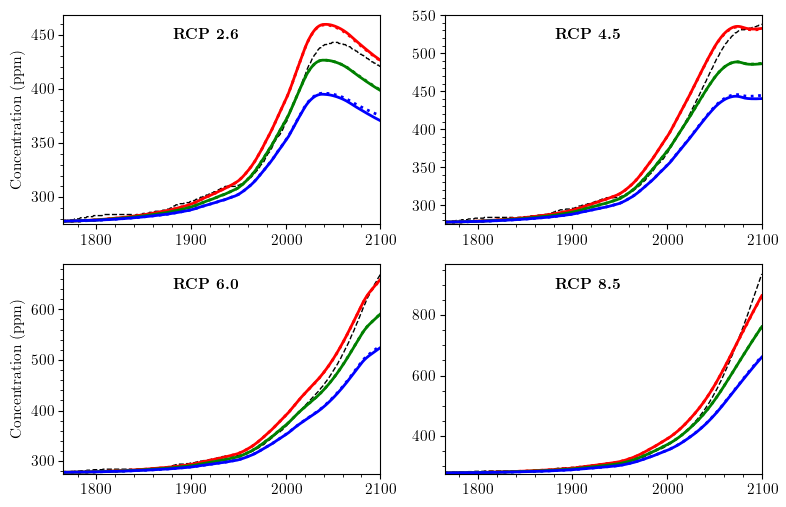

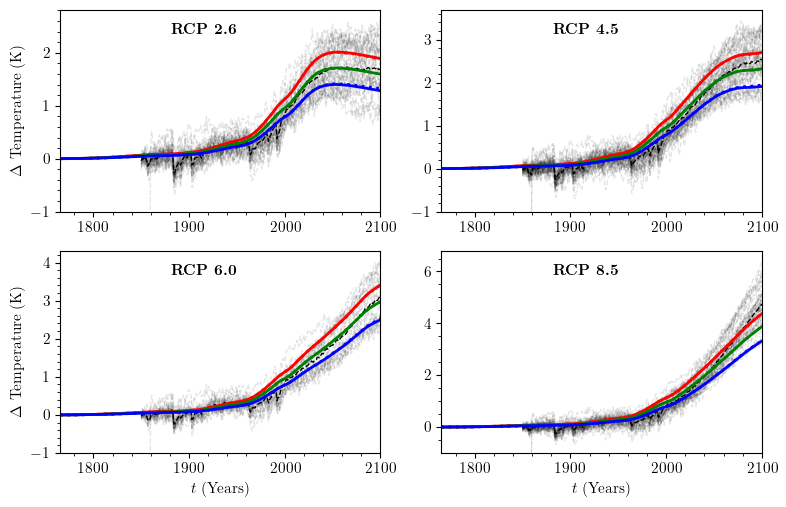

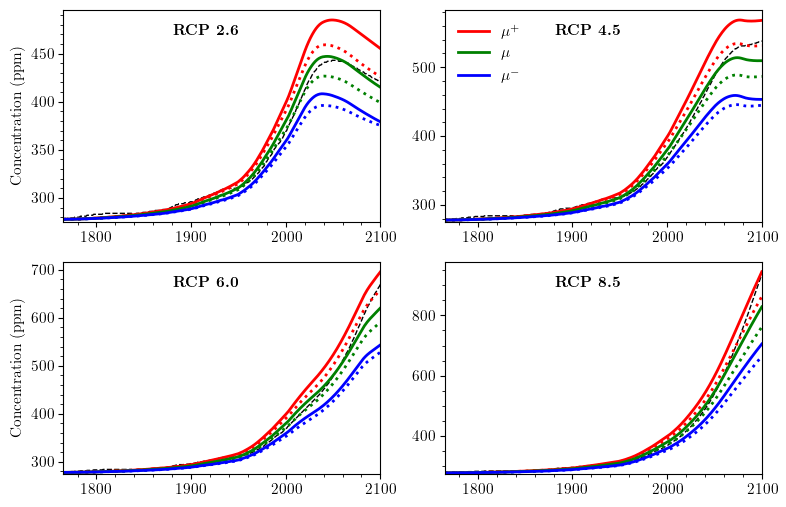

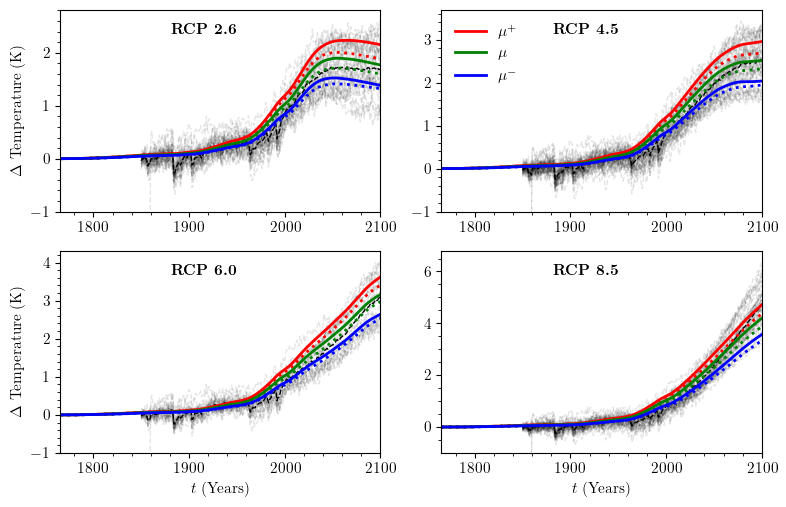

In [19]:
def plot_rcp_conc_temp(results,model_name_set,FX_ratio_set=[1.3,1.3],tag=''):

    T = T_end - T_start + 1
       
    scenerio_set       = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']
    scenerio_set_name  = [r'$\textbf{RCP 2.6}$', r'$\textbf{RCP 4.5}$', r'$\textbf{RCP 6.0}$', r'$\textbf{RCP 8.5}$']

    fig_conc, axs_conc = make_plot(2,2)
    fig_temp, axs_temp = make_plot(2,2)


    for i in range(2):
        for j in range(2):
            scenerio = scenerio_set[i*2+j]

            [emis_val     ,emis_year] = data_load.cmip_emission(     scenerio_name=scenerio  ,T_start=T_start,T_end=T_end,emission_type='fossil+land')  
            [emis_land_val,emis_year] = data_load.cmip_emission(     scenerio_name=scenerio  ,T_start=T_start,T_end=T_end,emission_type='land')    
            [conc_val     ,conc_year] = data_load.cmip_concentration(scenerio_name=scenerio  ,T_start=T_start,T_end=T_end,concentration_type='CO2')
            [temp_val     ,temp_year] = data_load.cmip_temperature(  scenerio_name=scenerio  ,T_start=T_start,T_end=T_end)

            temp_val = (temp_val.T - temp_val[:,0]).T

            temp_val[np.abs(temp_val)<1e-12]=np.nan
            
            axs_conc[i,j].plot(conc_year,conc_val           ,linewidth=1,alpha=1,color='black',linestyle='--',label='_Mean Concentration')
            axs_temp[i,j].plot(temp_year,temp_val.T         ,linewidth=1,alpha=.1,color='black',linestyle='--',label='_')
            axs_temp[i,j].plot(temp_year,np.nanmean(temp_val,0),linewidth=1,alpha=1,color='black',linestyle='--',label='_Mean Temperature')

            ###########
            # 3SR Model
            ###########
            if '3SR' in model_name_set:

                model  = results['3SR']['model']
                A      = results['3SR']['A']
                a      = results['3SR']['a']
                m_eq   = np.array(results['3SR']['m_eq'],dtype='f')
                c      = results['3SR']['c']
                
                e      = np.zeros(shape=(A.shape[0],len(emis_val)))
                e[0,:] = emis_val[0:T]

                [m_sim,temp_at,temp_o]  = operations.simulate_new(A=A*c[0],m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio_set[0])
                axs_conc[i,j].plot(emis_year,m_sim[0,:]/2.12, linewidth=2,alpha=1, label=r'_$\mu^-$',color='red',linestyle=':')
                axs_temp[i,j].plot(temp_year,temp_at        , linewidth=2,alpha=1, label=r'_$\mu^-$',color='red',linestyle=':')

                [m_sim,temp_at,temp_o]  = operations.simulate_new(A=A*c[1],m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio_set[0])
                axs_conc[i,j].plot(emis_year,m_sim[0,:]/2.12, linewidth=2,alpha=1, label=r'_$\mu$',color='green',linestyle=':')
                axs_temp[i,j].plot(temp_year,temp_at        , linewidth=2,alpha=1, label=r'_$\mu$',color='green',linestyle=':')

                [m_sim,temp_at,temp_o]  = operations.simulate_new(A=A*c[2],m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio_set[0])
                axs_conc[i,j].plot(emis_year,m_sim[0,:]/2.12, linewidth=2,alpha=1, label=r'_$\mu^-$',color='blue',linestyle=':')
                axs_temp[i,j].plot(temp_year,temp_at        , linewidth=2,alpha=1, label=r'_$\mu^-$',color='blue',linestyle=':')

            ###########
            # 4PR Model
            ###########
            if '4PR' in model_name_set:

                model  = results['4PR']['model']
                A      = results['4PR']['A']
                a      = results['4PR']['a']
                m_eq   = np.array(results['4PR']['m_eq'],dtype='f')
                c      = results['4PR']['c']
                
                e      = np.zeros(shape=(A.shape[0],len(emis_val)))
                e[0,:] = emis_val[0:T]

                [m_sim,temp_at,temp_o]  = operations.simulate_new(A=A*c[0],m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio_set[1])
                axs_conc[i,j].plot(emis_year,m_sim[0,:]/2.12, linewidth=2,alpha=1, label=r'_$\mu^-$',color='red',linestyle='-')
                axs_temp[i,j].plot(temp_year,temp_at        , linewidth=2,alpha=1, label=r'_$\mu^-$',color='red',linestyle='-')

                [m_sim,temp_at,temp_o]  = operations.simulate_new(A=A*c[1],m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio_set[1])
                axs_conc[i,j].plot(emis_year,m_sim[0,:]/2.12, linewidth=2,alpha=1, label=r'_$\mu$',color='green',linestyle='-')
                axs_temp[i,j].plot(temp_year,temp_at        , linewidth=2,alpha=1, label=r'_$\mu$',color='green',linestyle='-')

                [m_sim,temp_at,temp_o]  = operations.simulate_new(A=A*c[2],m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio_set[1])
                axs_conc[i,j].plot(emis_year,m_sim[0,:]/2.12, linewidth=2,alpha=1, label=r'_$\mu^-$',color='blue',linestyle='-')
                axs_temp[i,j].plot(temp_year,temp_at        , linewidth=2,alpha=1, label=r'_$\mu^-$',color='blue',linestyle='-')

            ###########
            # 4PR-X Model
            ###########
            if '4PR-X' in model_name_set:

                model  = results['4PR']['model']
                A      = results['4PR']['A']
                a      = results['4PR']['a']
                m_eq   = np.array(results['4PR']['m_eq'],dtype='f')
                c      = results['4PR']['c']
                
                e       = np.zeros(shape=(A.shape[0],len(emis_val)))
                e[0,:]  = emis_val[0:T]
                e[-1,:] = -1*emis_land_val[0:T]

                m_eq_update = np.copy(m_eq)
                A_set       = []

                for t,emis_land_val_t in enumerate(emis_land_val):
                    m_eq_update[-1] -= emis_land_val[t]
                    [A,_,_  ] = model(a,m_eq_update)
                    A_set.append(np.copy(A))

                A_set_u  = []
                A_set_m  = []
                A_set_d  = []

                for A in A_set:
                    A_set_d.append(np.copy(A)*c[0])
                    A_set_m.append(np.copy(A)*c[1])
                    A_set_u.append(np.copy(A)*c[2])

                [m_sim,temp_at,_]  = operations.simulate_dynamic_new(A_set=A_set_d,m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio_set[1])
                axs_conc[i,j].plot(emis_year,(m_sim[0,:])/2.12,  linewidth=2,alpha=1, label=r'$\mu^+$',color='red',linestyle='-') 
                axs_temp[i,j].plot(temp_year,temp_at,            linewidth=2,alpha=1, label=r'$\mu^+$',color='red',linestyle='-') 
                         
                [m_sim,temp_at,_]  = operations.simulate_dynamic_new(A_set=A_set_m,m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio_set[1])
                axs_conc[i,j].plot(emis_year,(m_sim[0,:])/2.12,  linewidth=2,alpha=1, label=r'$\mu$',color='green',linestyle='-') 
                axs_temp[i,j].plot(temp_year,temp_at,            linewidth=2,alpha=1, label=r'$\mu$',color='green',linestyle='-') 
     
                [m_sim,temp_at,_]  = operations.simulate_dynamic_new(A_set=A_set_u,m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio_set[1])
                axs_conc[i,j].plot(emis_year,(m_sim[0,:])/2.12,  linewidth=2,alpha=1, label=r'$\mu^-$',color='blue',linestyle='-') 
                axs_temp[i,j].plot(temp_year,temp_at,            linewidth=2,alpha=1, label=r'$\mu^-$',color='blue',linestyle='-') 

            axs_conc[i,j].minorticks_on() 
            axs_conc[i,j].set_ylim(bottom=275)
            axs_conc[i,j].set_xlim(left=T_start,right=T_end)
                
            axs_temp[i,j].minorticks_on()
            axs_temp[i,j].set_ylim(bottom=-1)
            axs_temp[i,j].set_xlim(left=T_start,right=T_end)

            axs_conc[i,j].text(0.45,.9,scenerio_set_name[i*2+j],horizontalalignment='center', verticalalignment='center', transform=axs_conc[i,j].transAxes)
            axs_temp[i,j].text(0.45,.9,scenerio_set_name[i*2+j],horizontalalignment='center', verticalalignment='center', transform=axs_temp[i,j].transAxes)

            #axs_conc[-1,0].set_xlabel(r'$t$ (Years)') 
            #axs_conc[-1,-1].set_xlabel(r'$t$ (Years)') 
            axs_conc[0,0].set_ylabel(r'Concentration (ppm)')
            axs_conc[-1,0].set_ylabel(r'Concentration (ppm)')
            
            axs_temp[0,0].set_ylabel(r'$\Delta$ Temperature (K)')
            axs_temp[-1,0].set_ylabel(r'$\Delta$ Temperature (K)')

            axs_temp[-1, 0].set_xlabel(r'$t$ (Years)') 
            axs_temp[-1, -1].set_xlabel(r'$t$ (Years)') 
            
            axs_conc[0,-1].legend(loc='upper left' ,frameon=False,ncol=1)
            axs_temp[0,-1].legend(loc='upper left' ,frameon=False,ncol=1)

    fig_conc.savefig('doc/fig/simulations_rcp_conc_'+str(tag)+'.png',dpi=300)
    fig_temp.savefig('doc/fig/simulations_rcp_temp_'+str(tag)+'.png',dpi=300) 
    

    
    
[_,rf_ratio,year]=data_load.reactive_forcing(T_start = T_start,T_end = T_end)

#print(year)

#plt.plot(year,val['RCP2.6'])
#plt.plot(year,val['RCP4.5'])
##plt.plot(year,val['RCP6.0'])
#plt.plot(year,val['RCP8.5'])
#plt.plot(year,val['avg'])


plot_rcp_conc_temp(results=_results,model_name_set=['3SR','4PR'],tag='base_both',FX_ratio_set=[rf_ratio['avg'],rf_ratio['avg']])
plot_rcp_conc_temp(results=_results,model_name_set=['3SR','4PR-X'],tag='base_both_x',FX_ratio_set=[rf_ratio['avg'],rf_ratio['avg']])
#plot_rcp_conc_temp(results=_results,model_name_set=['4PR','4PR-X'],tag='base_both',FX_ratio_set=[val['avg'],val['avg']])
#plot_rcp_conc_temp(results=_results,model_name_set=['3SR','4PR-X'],tag='base_both_X',FX_ratio_set=[val['avg'],val['avg']])

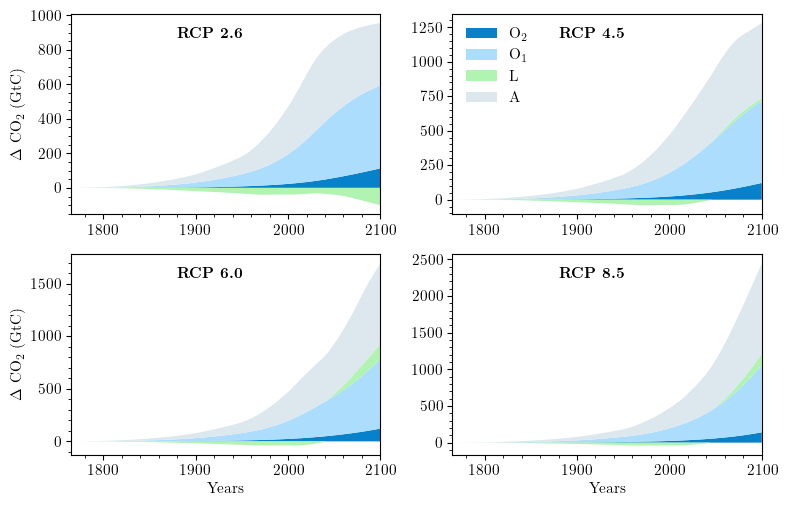

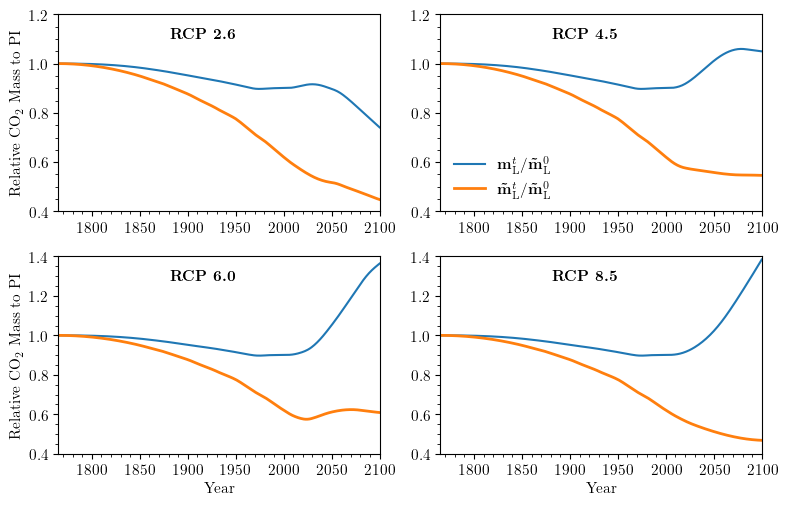

In [22]:

def plot_rcp_conc_comp(results,model_name ='4PR',FX_ratio=1.3,tag=''):

    T = T_end - T_start + 1
 
    color_A  =(0.8667,0.9059,0.9333)
    color_O1 =(0.6743529411764707, 0.8670274509803922, 0.9864313725490196)
    color_O2 =(0.03321568627450988, 0.5048784313725492, 0.7971764705882353)
    color_L  =(0.6946139705882354, 0.9532291666666667, 0.6946139705882354)

    scenerio_set       = ['RCP2.6', 'RCP4.5', 'RCP6.0', 'RCP8.5']
    scenerio_set_name  = [r'$\textbf{RCP 2.6}$', r'$\textbf{RCP 4.5}$', r'$\textbf{RCP 6.0}$', r'$\textbf{RCP 8.5}$']
    fig, axs = make_plot(2,2)

    fig_land, axs_land = make_plot(2,2)

    for i in range(2):
        for j in range(2):
            scenerio = scenerio_set[i*2+j]

            [emis_val     ,emis_year] = data_load.cmip_emission(     scenerio_name=scenerio  ,T_start=T_start,T_end=T_end,emission_type='fossil+land')  
            [emis_land_val,emis_year] = data_load.cmip_emission(     scenerio_name=scenerio  ,T_start=T_start,T_end=T_end,emission_type='land')    
            [conc_val     ,conc_year] = data_load.cmip_concentration(scenerio_name=scenerio  ,T_start=T_start,T_end=T_end,concentration_type='CO2')
            [temp_val     ,temp_year] = data_load.cmip_temperature(  scenerio_name=scenerio  ,T_start=T_start,T_end=T_end)

            temp_val = (temp_val.T - temp_val[:,0]).T

            ###########
            # 3SR Model
            ###########
            if '3SR' in model_name:

                model  = results['3SR']['model']
                A      = results['3SR']['A']
                a      = results['3SR']['a']
                m_eq   = np.array(results['3SR']['m_eq'],dtype='f')
                c      = results['3SR']['c']
                
                e      = np.zeros(shape=(A.shape[0],len(emis_val)))
                e[0,:] = emis_val[0:T]

                [m_sim,temp_at,temp_o]  = operations.simulate_new(A=A*c[0],m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio)
                m_sim_3sr_1   = m_sim
                temp_at_3sr_1 = temp_at

                [m_sim,temp_at,temp_o]  = operations.simulate_new(A=A*c[1],m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio)
                m_sim_3sr_2   = m_sim
                temp_at_3sr_2 = temp_at

                [m_sim,temp_at,temp_o]  = operations.simulate_new(A=A*c[2],m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio)
                m_sim_3sr_3   = m_sim
                temp_at_3sr_3 = temp_at

                D = copy.copy(m_sim_3sr_2)

                for ii in range(0,D.shape[0]):
                    D[ii,:]=D[ii,:]-m_eq[ii]

                axs[i,j].stackplot(range(T_start, T_end+1),D[2,:],D[1,:],D[0,:], colors=[color_O2,color_O1,color_A])
                axs[i,j].set_xlim(left=T_start,right=T_end)
                #axs[i,j].set_ylim(bottom=0)
                axs[i,j].text(0.45,.9,scenerio_set_name[i*2+j],horizontalalignment='center', verticalalignment='center', transform=axs[i,j].transAxes)
                axs[i,j].minorticks_on() 
 
            ###########
            # 4PR Model
            ###########
            if '4PR' in model_name:

                model  = results['4PR']['model']
                A      = results['4PR']['A']
                a      = results['4PR']['a']
                m_eq   = np.array(results['4PR']['m_eq'],dtype='f')
                c      = results['4PR']['c']
                
                e       = np.zeros(shape=(A.shape[0],len(emis_val)))
                e[0,:]  = emis_val[0:T]
                #e[-1,:] = -1*emis_land_val[0:T]

                m_eq_update = np.copy(m_eq)
                A_set       = []

                for t,emis_land_val_t in enumerate(emis_land_val):
                    m_eq_update[-1] -= emis_land_val[t] 
                    [A,_,_  ] = model(a,m_eq_update)
                    A_set.append(np.copy(A))

                A_set_u  = []
                A_set_m  = []
                A_set_d  = []

                for A in A_set:
                    A_set_d.append(np.copy(A)*c[0])
                    A_set_m.append(np.copy(A)*c[1])
                    A_set_u.append(np.copy(A)*c[2])

                [m_sim_4pr_1,temp_at_4pr_1,_]  = operations.simulate_dynamic_new(A_set=A_set_d,m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio)
                [m_sim_4pr_2,temp_at_4pr_2,_]  = operations.simulate_dynamic_new(A_set=A_set_m,m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio)
                [m_sim_4pr_3,temp_at_4pr_3,_]  = operations.simulate_dynamic_new(A_set=A_set_u,m0=m_eq,T=len(emis_val),e=e,FX_ratio=FX_ratio)

                D = copy.copy(m_sim_4pr_2)

                for ii in range(0,D.shape[0]):
                    D[ii,:]=D[ii,:]-m_eq[ii]

                D_neg = copy.copy(D)
                D_pos = copy.copy(D)

                D_pos[D_pos < 0] = 0
                D_neg[D_neg > 0] = 0

                axs[i,j].stackplot(range(T_start, T_end+1),D_pos[2,:],D_pos[1,:],D_pos[3,:],D_pos[0,:], colors=[color_O2,color_O1,color_L,color_A])
                axs[i,j].stackplot(range(T_start, T_end+1),D_neg[2,:],D_neg[1,:],D_neg[3,:],D_neg[0,:], colors=[color_O2,color_O1,color_L,color_A])
            
                axs[i,j].minorticks_on() 
                axs[i,j].text(0.45,.9,scenerio_set_name[i*2+j],horizontalalignment='center', verticalalignment='center', transform=axs[i,j].transAxes)
     

                axs_land[i,j].plot(range(T_start, T_end+1), m_sim_4pr_2[-1,:]/m_sim_4pr_2[-1,0])
                temp = m_eq[-1]-np.cumsum(emis_land_val)
                axs_land[i,j].plot(range(T_start, T_end+1),temp/temp[0],linewidth=2,alpha=1, linestyle='-') 
                axs_land[i,j].minorticks_on() 
                axs_land[i,j].text(0.45,.9,scenerio_set_name[i*2+j],horizontalalignment='center', verticalalignment='center', transform=axs_land[i,j].transAxes)

    axs[0,0].set_xlim(left=T_start,right=T_end)
    axs[0,0].set_ylabel(r'$\Delta$ CO$_2$ (GtC)')

    axs[0,1].set_xlim(left=T_start,right=T_end)
    axs[0,1].legend([r'$\textrm{O}_2$',r'$\textrm{O}_1$',r'$\textrm{L}$',r'$\textrm{A}$'],frameon=False,loc='upper left',ncol=1)

    axs[1,0].set_xlim(left=T_start,right=T_end)
    axs[1,0].set_ylabel(r'$\Delta$ CO$_2$ (GtC)')
    axs[1,0].set_xlabel(r'Years') 

    axs[1,1].set_xlim(left=T_start,right=T_end)
    axs[1,1].set_xlabel(r'Years') 

    axs_land[0,0].set_xlim(left=T_start,right=T_end)
    axs_land[0,0].set_ylim(bottom=0.4,top=1.2)
    axs_land[0,0].set_ylabel(r'Relative CO$_2$ Mass to PI')

    axs_land[0,1].set_xlim(left=T_start,right=T_end)
    axs_land[0,1].set_ylim(bottom=0.4,top=1.2)
    axs_land[0,1].legend([r'$\mathbf{m}^t_{\text{L}}/\mathbf{\tilde{m}}^0_{\text{L}}$',r'$\mathbf{\tilde{m}}^t_{\text{L}}/\mathbf{\tilde{m}}^0_{\text{L}}$'],frameon=False,loc='lower left',ncol=1)

    axs_land[1,0].set_xlim(left=T_start,right=T_end)
    axs_land[1,0].set_ylim(bottom=0.4,top=1.4)
    axs_land[1,0].set_ylabel(r'Relative CO$_2$ Mass to PI')
    axs_land[1,0].set_xlabel(r'Year') 

    axs_land[1,1].set_xlim(left=T_start,right=T_end)
    axs_land[1,1].set_ylim(bottom=0.4,top=1.4)
    axs_land[1,1].set_xlabel(r'Year') 

    fig.savefig('doc/fig/simulations_plot_rcp_conc_comp_'+str(tag)+'.png',dpi=300) 
    fig_land.savefig('doc/fig/simulations_plot_rcp_conc_land_change_'+str(tag)+'.png',dpi=300) 

plot_rcp_conc_comp(results=_results,model_name='4PR',tag='base_4PR_x',FX_ratio=1.3)

#plot_rcp_conc_temp(results=_results,model_name=['3SR','4PR'],zeta=0.8,alpha_new=.5,tag='mod_both',FX_ratio=1.3)
#plot_rcp_conc_comp(results=_results,model_name='4PR',zeta=0.8,tag='mod_4PR',FX_ratio=1.3)

Mc dog

In [17]:
def macdougall_emission(results,model):

    T_mac_dougall        = 100
    m_sim_set            = [0]*3
    temp_sim_set         = [0]*3
    T_stop_emissions_set = [0]*3


    for c in results[model]['c']:

        A        = results[model]['A']*c
        m_sim    = [results[model]['m_eq']]
        emis_val = [0]

        # produce emission such that we increase CO2 by 1% per year and stop when we have 1000 GTC carbon
        while np.sum(emis_val) < 1000*.99:

            # m_new = Am + m + e
            # 1.01  = m_new/m = (Am + m)/m + e/m = A+1+e/m
            # e/m   = (1.01 - (Am - m)/m) =  0.1 - A
            # e     = (1.01*m - Am - m) = (m*(1.01-1) - Am)= (0.01*m-Am)

            m  = np.copy(m_sim[-1])
            Am = A@m

            # compute emissions to get 1% increase
            emis_val += [1.0/100.0 * m[0] - Am[0]]
            m[0]     += emis_val[-1]
            m_sim    += [Am + m]

        T_stop_emissions_set_3sr.append(len(emis_val))

        emis_val = emis_val + [0]*T_mac_dougall

        e = np.zeros(shape=(A.shape[0],len(emis_val)))
        e[0,:] = emis_val

        [m_sim,temp_at,temp_o] = operations.simulate(A=A, m0=m_eq, T=e.shape[1], e=e)

        m_sim_set_3sr.append(m_sim)
        temp_at_sim_set_3sr.append(temp_at)
        temp_o_sim_set_3sr.append(temp_o)


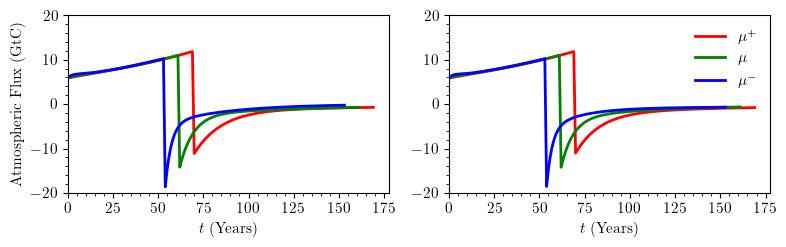

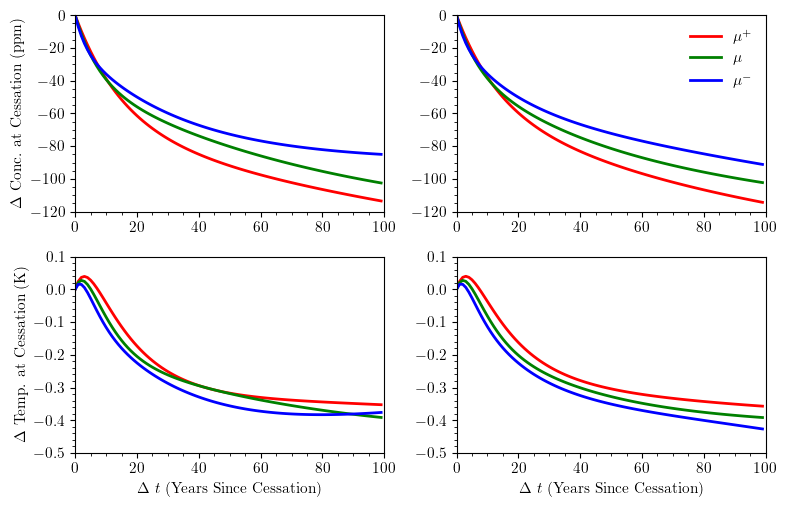

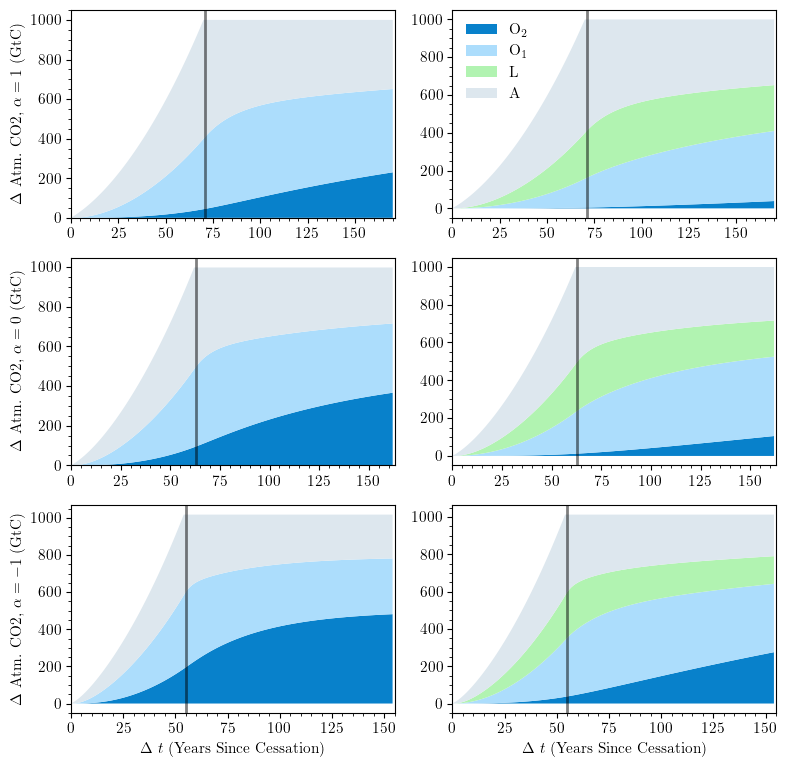

In [18]:
def plot_mcdoogle(results):

    color_A  =(0.8667,0.9059,0.9333)
    color_O1 =(0.6743529411764707, 0.8670274509803922, 0.9864313725490196)
    color_O2 =(0.03321568627450988, 0.5048784313725492, 0.7971764705882353)
    color_L  =(0.6946139705882354, 0.9532291666666667, 0.6946139705882354)

    calib_dataset = ['$\mu^+$','$\mu$','$\mu^-$']

    calib_data_3sr = results['3SR'] #operations.load_results(root=root,test_name=test_name_set[0] ,T_sim_set=[10,100,500,1000])
    calib_data_4pr = results['4PR'] #operations.load_results(root=root,test_name=test_name_set[1] ,T_sim_set=[10,100,500,1000])

    T_mac_dougall        = 100
    m_sim_set            = [0]*3
    temp_sim_set         = [0]*3
    T_stop_emissions_set = [0]*3

    ###############
    ## 3SR
    ###############
    T_stop_emissions_set_3sr = []
    m_sim_set_3sr            = []
    temp_at_sim_set_3sr      = []
    temp_o_sim_set_3sr       = []

    c_set     = calib_data_3sr['c'] #[ alpha_data['3SR'][0], 1 ,alpha_data['3SR'][1]]
    A_base    = calib_data_3sr['A']
    m_eq      = calib_data_3sr['m_eq']

    for c in c_set:

        A        = A_base*c
        m_sim    = [m_eq]
        emis_val = [0]

        # produce emission such that we increase CO2 by 1% per year and stop when we have 1000 GTC carbon
        while np.sum(emis_val) < 1000*.99:

            # m_new = Am + m + e
            # 1.01  = m_new/m = (Am + m)/m + e/m = A+1+e/m
            # e/m   = (1.01 - (Am - m)/m) =  0.1 - A
            # e     = (1.01*m - Am - m) = (m*(1.01-1) - Am)= (0.01*m-Am)

            m  = np.copy(m_sim[-1])
            Am = A@m

            # compute emissions to get 1% increase
            emis_val += [1.0/100.0 * m[0] - Am[0]]
            m[0]     += emis_val[-1]
            m_sim    += [Am + m]

        T_stop_emissions_set_3sr.append(len(emis_val))

        emis_val = emis_val + [0]*T_mac_dougall

        e = np.zeros(shape=(A.shape[0],len(emis_val)))
        e[0,:] = emis_val

        [m_sim,temp_at,temp_o] = operations.simulate(A=A, m0=m_eq, T=e.shape[1], e=e)

        m_sim_set_3sr.append(m_sim)
        temp_at_sim_set_3sr.append(temp_at)
        temp_o_sim_set_3sr.append(temp_o)

    ###############
    ## 4PR
    ###############
    T_stop_emissions_set_4pr = []
    m_sim_set_4pr            = []
    temp_at_sim_set_4pr      = []
    temp_o_sim_set_4pr       = []

    c_set     = calib_data_4pr['c'] #
    A_base    = calib_data_4pr['A']
    m_eq      = calib_data_4pr['m_eq']

    for c in c_set:

        A        = A_base*c
        m_sim    = [m_eq]
        emis_val = [0]

        # produce emission such that we increase CO2 by 1% per year and stop when we have 1000 GTC carbon
        while np.sum(emis_val) < 1000*.99:

            # m_new = Am + m + e
            # 1.01  = m_new/m = (Am + m)/m + e/m
            # e/m   = (1.01 - (Am - m)/m)
            # e     = (1.01*m - Am - m) = (m*(1.01-1) - Am)= (0.01*m-Am)
            m  = np.copy(m_sim[-1])
            Am = A@m

            # compute emissions to get 1% increase
            emis_val += [1.0/100.0 * m[0] - Am[0]]
            m[0]     += emis_val[-1]
            m_sim    += [Am + m]

        T_stop_emissions_set_4pr.append(len(emis_val))

        emis_val = emis_val + [0] * T_mac_dougall

        e = np.zeros(shape=(A.shape[0],len(emis_val)))
        e[0,:] = emis_val

        [m_sim,temp_at,temp_o] = operations.simulate(A=A, m0=m_eq, T=e.shape[1], e=e)

        m_sim_set_4pr.append(m_sim)
        temp_at_sim_set_4pr.append(temp_at)
        temp_o_sim_set_4pr.append(temp_o)

    T_stop_emissions_set = [T_stop_emissions_set_3sr,T_stop_emissions_set_4pr]
    m_sim_set            = [m_sim_set_3sr,m_sim_set_4pr]
    temp_at_sim_set      = [temp_at_sim_set_3sr,temp_at_sim_set_4pr]
    temp_o_sim_set       = [temp_o_sim_set_3sr,temp_o_sim_set_4pr]

    #######################
    # Plot Delta ATM
    #######################
    fig, axs = make_plot(1,2)
    for i in range(2):

        data = np.copy(m_sim_set[i][0])
        data = np.diff(data[0, :])
        axs[0, i].plot(data, linewidth=2, alpha=1,label=r'$\mu^+$', color='red')
            
        data = np.copy(m_sim_set[i][1])
        data = np.diff(data[0, :])
        axs[0, i].plot(data, linewidth=2, alpha=1,label=r'$\mu$', color='green')
            
        data = np.copy(m_sim_set[i][2])
        data = np.diff(data[0, :])
        axs[0, i].plot(data, linewidth=2, alpha=1,label=r'$\mu^-$', color='blue')
        
        axs[0, i].set_xticks(np.arange(0, 200, 25))
        axs[0, i].set_xlim(left=0)
        axs[0, i].set_ylim(-20, 20)
        axs[0, i].minorticks_on()
        axs[0, i].set_xlabel(r'$t$ (Years)') 


    axs[0, -1].legend(frameon=False, loc='upper right', ncol=1)
    axs[0, 0].set_ylabel(r'Atmospheric Flux (GtC)')
    fig.savefig('doc/fig/simulate_macdougall_flux.png', dpi=300)


    #######################
    # Plot Concentration ATM & Temp
    #######################
    fig, axs = make_plot(2,2)
    for i in range(2):

        data = np.copy(m_sim_set[i][0])
        data = data[0,T_stop_emissions_set[i][0]:] - m_sim_set[i][0][0,T_stop_emissions_set[i][0]]
        axs[0, i].plot(data/2.12, linewidth=2, alpha=1,label=r'$\mu^+$', color='red')
            
        data = np.copy(m_sim_set[i][1])
        data = data[0,T_stop_emissions_set[i][1]:] - m_sim_set[i][1][0,T_stop_emissions_set[i][1]]
        axs[0, i].plot(data/2.12, linewidth=2, alpha=1,label=r'$\mu$', color='green')
            
        data = np.copy(m_sim_set[i][2])
        data = data[0,T_stop_emissions_set[i][2]:] - m_sim_set[i][2][0,T_stop_emissions_set[i][2]]
        axs[0, i].plot(data/2.12, linewidth=2, alpha=1,label=r'$\mu^-$', color='blue')

        #axs[0, 1].set_xticks(np.arange(0, 200, 25))
        axs[0, i].set_ylim(-120, 0)
        axs[0,i].set_xlim(0, 100)
        axs[0,i].minorticks_on()
        #axs[0,i].legend(frameon=False, loc='upper right', ncol=1)
        #axs[0,i].set_xlabel(r'$\Delta$ $t$ (Years Since Cessation)') 
    
    axs[0,-1].legend(frameon=False, loc='upper right', ncol=1)
    axs[0,0].set_ylabel(r'$\Delta$ Conc. at Cessation (ppm)')
    #fig.savefig('doc/fig/simulate_macdougall_2.png', dpi=300)

    #######################
    # Plot Temp
    #######################
    #fig, axs = make_plot(1,2)
    for i in range(2):

        #label_set_i = label_set[i]
        #data_i = temp_at_sim_set[i]

        data = np.copy(temp_at_sim_set[i][0])
        data = data[T_stop_emissions_set[i][0]:] -  temp_at_sim_set[i][0][T_stop_emissions_set[i][0]]
        axs[1, i].plot(data, linewidth=2, alpha=1,label=r'$\mu^+$', color='red')
            
        data = np.copy(temp_at_sim_set[i][1])
        data = data[T_stop_emissions_set[i][1]:] -  temp_at_sim_set[i][1][T_stop_emissions_set[i][1]]
        axs[1, i].plot(data, linewidth=2, alpha=1,label=r'$\mu$', color='green')
            
        data = np.copy(temp_at_sim_set[i][2])
        data = data[T_stop_emissions_set[i][2]:] -  temp_at_sim_set[i][2][T_stop_emissions_set[i][2]]
        axs[1, i].plot(data, linewidth=2, alpha=1,label=r'$\mu^-$', color='blue')

        
           # data = np.copy(data_i[inx])
           # data = data[T_stop_emissions_set[i][inx]:] -  data_i[1][T_stop_emissions_set[i][1]]
           # data = data/2.12
           # axs[1, i].plot(data, linewidth=2, alpha=1,label=test_type_style[inx][0], color=test_type_style[inx][1])

        #axs[0, 1].set_xticks(np.arange(0, 200, 25))
        axs[1, i].set_ylim(-0.5, .1)
        axs[1, i].set_xlim(0, 100)
        axs[1, i].minorticks_on()
        axs[1, i].set_xlabel(r'$\Delta$ $t$ (Years Since Cessation)') 

    #axs[1, -1].legend(frameon=False, loc='upper right', ncol=1)
    axs[1, 0].set_ylabel(r'$\Delta$ Temp. at Cessation (K)')
    fig.savefig('doc/fig/simulate_macdougall_conc_temp.png', dpi=300)

    fig, axs = make_plot(3,2)
    for i in range(0,2):
        for inx in range(0,3):
            data = np.copy(m_sim_set[i][inx])
            p, T = data.shape

            for j in range(0, p):
                data[j, :] = data[j, :] - m_sim_set[i][inx][j, 0]

            if i==0: # 3SR 
                axs[inx,i].stackplot(range(0, T),data[2,:],data[1,:],data[0,:], colors=[color_O2,color_O1,color_A])

            if i==1: # 4PR 
                axs[inx,i].stackplot(range(0, T),data[2,:],data[1,:],data[3,:],data[0,:], colors=[color_O2,color_O1,color_L,color_A])

            axs[inx,i].axvline(x=T_stop_emissions_set[i][inx], color='black',alpha=0.5, linewidth=2)

            axs[inx,i].minorticks_on()
            axs[inx,i].set_xlim(left=0,right=T)
            axs[inx,0].set_ylabel(r'$\Delta$ Atm. CO2, $\alpha='+str(1-inx)+'$ (GtC)')

    axs[0,-1].legend([r'$\textrm{O}_2$',r'$\textrm{O}_1$',r'$\textrm{L}$',r'$\textrm{A}$'],frameon=False,loc='upper left',ncol=1)

    axs[-1,0].set_xlabel(r'$\Delta$ $t$ (Years Since Cessation)') 
    axs[-1,1].set_xlabel(r'$\Delta$ $t$ (Years Since Cessation)') 

    fig.savefig('doc/fig/simulate_macdougall_absorbtion.png', dpi=300)
  
#plot_mcdoogle(test_name_set=[_test_name_base,_test_name_sel])
plot_mcdoogle(results=_results)